In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split




In [2]:
# 1. Load dataset
data = load_breast_cancer()
X = data.data
y = data.target   # 0 = malignant, 1 = benign



In [3]:
# 2. Scale data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)



In [4]:
# 3. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)



In [5]:
# Use only "normal" data (benign = 1) for training the autoencoder
X_train_normal = X_train[y_train == 1]



In [6]:
# 4. Build autoencoder
input_dim = X_train_normal.shape[1]
encoding_dim = 14  # bottleneck

input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation="relu")(input_layer)
encoder = Dense(7, activation="relu")(encoder)
decoder = Dense(encoding_dim, activation="relu")(encoder)
decoder = Dense(input_dim, activation="linear")(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer="adam", loss="mse")



In [7]:
# 5. Train autoencoder only on normal data
history = autoencoder.fit(
    X_train_normal, X_train_normal,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)



Epoch 1/50
9/9 [==============================] - 4s 44ms/step - loss: 0.7614 - val_loss: 0.8542
Epoch 2/50
9/9 [==============================] - 0s 16ms/step - loss: 0.7213 - val_loss: 0.8127
Epoch 3/50
9/9 [==============================] - 0s 14ms/step - loss: 0.6933 - val_loss: 0.7801
Epoch 4/50
9/9 [==============================] - 0s 13ms/step - loss: 0.6713 - val_loss: 0.7523
Epoch 5/50
9/9 [==============================] - 0s 14ms/step - loss: 0.6481 - val_loss: 0.7241
Epoch 6/50
9/9 [==============================] - 0s 15ms/step - loss: 0.6229 - val_loss: 0.6975
Epoch 7/50
9/9 [==============================] - 0s 14ms/step - loss: 0.5974 - val_loss: 0.6705
Epoch 8/50
9/9 [==============================] - 0s 13ms/step - loss: 0.5711 - val_loss: 0.6417
Epoch 9/50
9/9 [==============================] - 0s 14ms/step - loss: 0.5431 - val_loss: 0.6095
Epoch 10/50
9/9 [==============================] - 0s 14ms/step - loss: 0.5174 - val_loss: 0.5808
Epoch 11/50
9/9 [============

In [8]:
# 6. Reconstruction error for test data
X_test_pred = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - X_test_pred, 2), axis=1)


4/4 [==============================] - 0s 3ms/step


In [9]:

# 7. Set threshold (mean + 2*std of training error)
X_train_pred = autoencoder.predict(X_train_normal)
train_mse = np.mean(np.power(X_train_normal - X_train_pred, 2), axis=1)
threshold = np.mean(train_mse) + 2*np.std(train_mse)



9/9 [==============================] - 0s 4ms/step


In [10]:
# 8. Predictions
y_pred = (mse > threshold).astype(int)  # 1 = anomaly (malignant), 0 = normal

# Map actual: benign=1(normal)->0 , malignant=0(anomaly)->1
y_true = (y_test == 0).astype(int)



In [11]:
# 9. Evaluation
from sklearn.metrics import classification_report, confusion_matrix

print("Threshold:", threshold)
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
print("Classification Report:\n", classification_report(y_true, y_pred))

Threshold: 0.6747283527169304
Confusion Matrix:
 [[69  2]
 [20 23]]
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.97      0.86        71
           1       0.92      0.53      0.68        43

    accuracy                           0.81       114
   macro avg       0.85      0.75      0.77       114
weighted avg       0.83      0.81      0.79       114



In [12]:
import pandas as pd

# Put results into a DataFrame for inspection
results = pd.DataFrame(X_test, columns=data.feature_names)
results["Reconstruction_Error"] = mse
results["True_Label"] = y_true  # 0=normal, 1=anomaly
results["Predicted_Label"] = y_pred

# Show top anomalies detected
anomalies = results[results["Predicted_Label"] == 1]
print("Detected anomalies (first 10):")
print(anomalies.head(10))


Detected anomalies (first 10):
    mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
1      1.366877      0.470149        1.302886   1.351264        -0.446227   
5      1.838341      2.336457        1.982524   1.735218         1.525767   
6      2.238801      0.607446        2.274975   2.352388         0.707364   
15     1.412320      1.629029        1.529432   1.356952         1.789079   
19     1.824140      0.365431        1.887787   1.857514         0.586383   
22     2.125195      0.695875        2.159642   2.139081         1.447485   
29     0.872693      1.217138        0.915698   0.780737         0.764297   
51     1.278833      1.354435        1.352314   1.231812         0.714481   
53    -0.053194     -1.424083       -0.068336  -0.172606         2.023925   
57     3.150487      1.307894        3.275896   3.478653         0.707364   

    mean compactness  mean concavity  mean concave points  mean symmetry  \
1          -0.027309        0.241064         

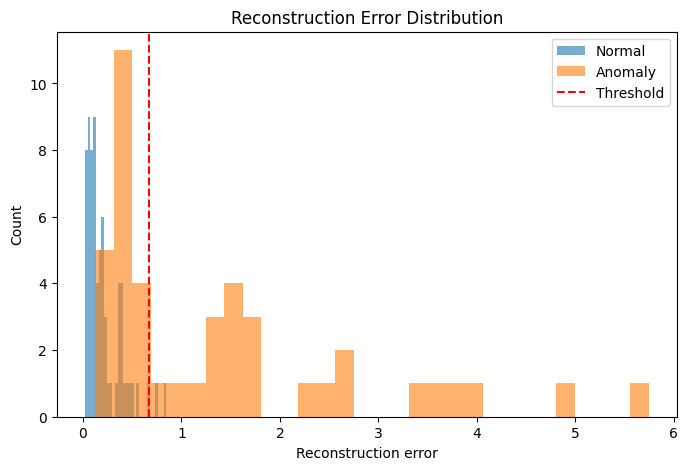

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.hist(mse[y_true == 0], bins=30, alpha=0.6, label="Normal")
plt.hist(mse[y_true == 1], bins=30, alpha=0.6, label="Anomaly")
plt.axvline(threshold, color='red', linestyle='--', label="Threshold")
plt.xlabel("Reconstruction error")
plt.ylabel("Count")
plt.legend()
plt.title("Reconstruction Error Distribution")
plt.show()
